## General Test

In [1]:
!git clone https://github.com/jorge-pessoa/pytorch-msssim

Cloning into 'pytorch-msssim'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 172 (delta 17), reused 17 (delta 6), pack-reused 136 (from 1)
Receiving objects: 100% (172/172), 1.25 MiB | 34.46 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [2]:
%cd pytorch-msssim
!python setup.py install
import pytorch_msssim
%cd /content

/content/pytorch-msssim
/usr/local/lib/python3.11/dist-packages/setuptools/dist.py:491: SetuptoolsDeprecationWarning: Invalid dash-separated options
!!

        ********************************************************************************
        Usage of dash-separated 'description-file' will not be supported in future
        versions. Please use the underscore name 'description_file' instead.

        This deprecation is overdue, please update your project and remove deprecated
        calls to avoid build errors in the future.

        See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
        ********************************************************************************

!!
  opt = self.warn_dash_deprecation(opt, section)
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        **************************************************************************

In [3]:
import io
import os
import random
from tqdm import tqdm

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from einops import rearrange
from einops.layers.torch import Rearrange

from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

from PIL import Image, ImageOps
import torch.nn.functional as Func
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode


#from torch import nn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage.metrics import structural_similarity as ssim

In [4]:
# LOAD DATASET FROM GOOGLE DRIVE FOLDER

# Authenticate with Google Drive
auth.authenticate_user()

# Create a Google Drive API service
drive_service = build('drive', 'v3')

def download_files_from_folder(folder_id, destination_folder):
  """Downloads all files from a Google Drive folder to a local folder.

  Args:
    folder_id: The ID of the Google Drive folder.
    destination_folder: The path to the local folder where files will be downloaded.
  """

  # Create the destination folder if it doesn't exist
  os.makedirs(destination_folder, exist_ok=True)

  page_token = None
  while True:
    # Query for files in the folder, including pagination
    results = drive_service.files().list(
        q=f"'{folder_id}' in parents",
        fields="nextPageToken, files(id, name)",
        pageToken=page_token
    ).execute()
    items = results.get('files', [])

    # Download each file
    for item in items:
      file_id = item['id']
      file_name = item['name']
      file_path = os.path.join(destination_folder, file_name)

      request = drive_service.files().get_media(fileId=file_id)
      fh = io.BytesIO()
      downloader = MediaIoBaseDownload(fh, request)
      done = False
      while done is False:
        status, done = downloader.next_chunk()
        #print(f"Download {int(status.progress() * 100)}%.")

      with open(file_path, 'wb') as f:
        f.write(fh.getbuffer())

      #print(f"Downloaded '{file_name}' to '{file_path}'")

    # Get the next page token
    page_token = results.get('nextPageToken', None)
    if page_token is None:
      break  # No more pages


folder_id = '1VkS3RHkAjiKjJ6DnZmEKZ_nUv4w6pz7P'
destination_folder = '/content/dataset'
download_files_from_folder(folder_id, destination_folder)

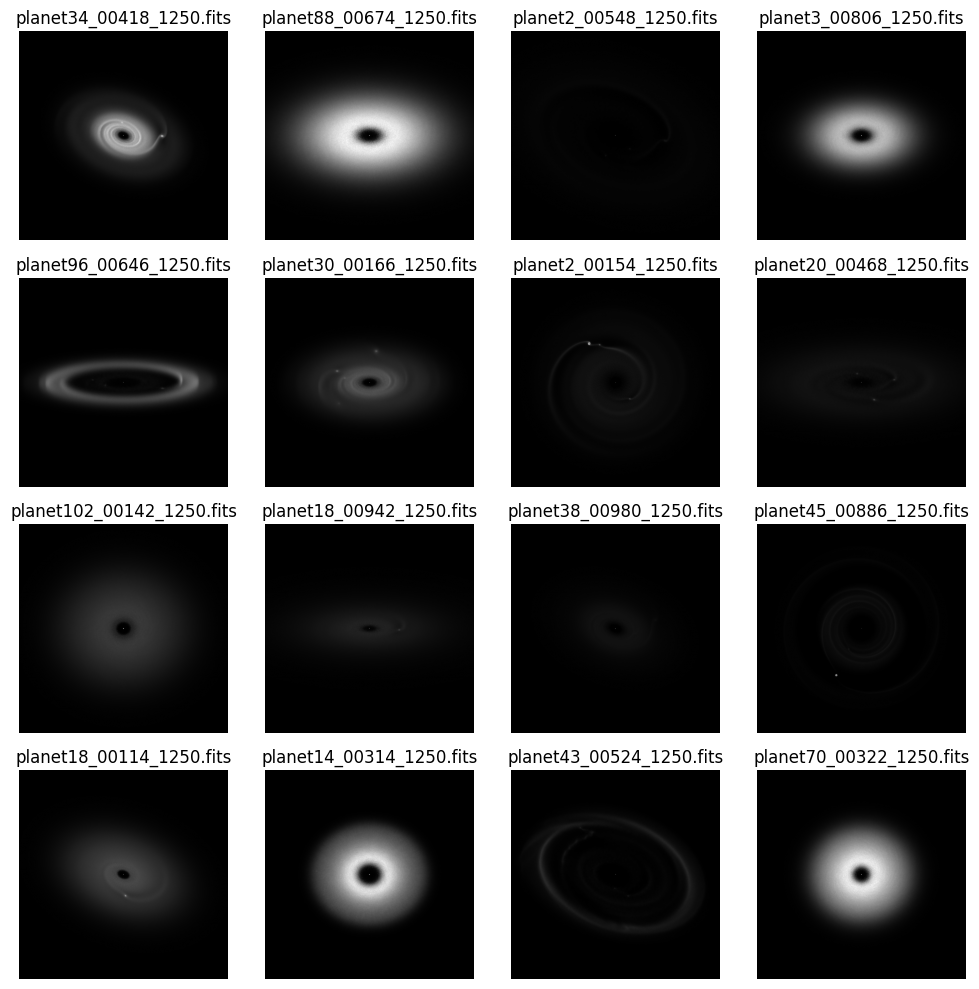

In [5]:
# DISPLAY 16 RANDOM IMAGES FROM THE DATASET

# Define dataset folder
dataset_folder = "/content/dataset/"

# Get list of FITS files in the dataset folder
fits_files = [f for f in os.listdir(dataset_folder) if f.endswith(".fits")]

# Select 16 random FITS files
selected_files = random.sample(fits_files, 16)

# Create a figure for displaying images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i, file in enumerate(selected_files):
    file_path = os.path.join(dataset_folder, file)

    # Open the FITS file
    with fits.open(file_path) as hdul:
        data = hdul[0].data  # Access primary data

    # Extract the relevant 2D slice (assuming data has shape (1, 1, 1, H, W))
    data = data[0, 0, 0] if data.ndim == 5 else data  # Adjust as needed

    # Display the image
    axes[i].imshow(np.log1p(data), cmap="gray")
    axes[i].set_title(file)
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [6]:
# COMPILE DATASET INTO NUMPY ARRAY

dataset_folder = "/content/dataset/"

# Get list of all FITS files
fits_files = [f for f in os.listdir(dataset_folder) if f.endswith(".fits")]

# Initialize a list to hold each image array
all_images = []

for file in fits_files:
    file_path = os.path.join(dataset_folder, file)

    with fits.open(file_path) as hdul:
        data = hdul[0].data

        # Extract a specific 2D image slice (adapt as needed)
        if data.ndim == 5:
            image = data[0, 0, 0]
        elif data.ndim == 4:
            image = data[0, 0]
        elif data.ndim == 3:
            image = data[0]
        else:
            image = data

        all_images.append(image)

# Stack into a single NumPy array
dataset_array = np.stack(all_images)

# Save to disk
np.save("compiled_fits_dataset.npy", dataset_array)

print(f"Compiled dataset shape: {dataset_array.shape}")

Compiled dataset shape: (150, 600, 600)


In [7]:
# CUSTOM ADAPTIVE BRIGHTNESS FUNCTION

def adaptive_brightness(image, clip_limit=(0, 99)):#.99696
    """
    Perform adaptive brightness/contrast enhancement on float images
    using percentile-based normalization.

    Args:
        image (np.ndarray): Grayscale image (H, W), float values.
        clip_limit (tuple): Percentiles to clip (default: (1, 99))

    Returns:
        np.ndarray: Brightness-adjusted image (still float)
    """
    # Compute lower and upper percentiles
    lower = np.percentile(image, clip_limit[0])
    upper = np.percentile(image, clip_limit[1])

    # Avoid divide-by-zero
    if upper - lower < 1e-22:
        return np.zeros_like(image)

    # Contrast stretch within percentile range
    stretched = np.clip((image - lower) / (upper - lower), 0, 1)

    return stretched


In [8]:
# FUNCTION TO VISUALIZE DATASET(IN PAGES) WITH ADAPTIVE BRIGHTNESS APPLIED

def visualize_page(dataset_array, page=1, images_per_page=10, cmap='gray'):
    """
    Visualizes a page of images from a (N, H, W) numpy array.

    Args:
        dataset_array (np.ndarray): Array of shape (150, H, W)
        page (int): Page number (1-based). Page 1 = first 10, Page 2 = next 10, etc.
        images_per_page (int): Number of images per page
        cmap (str): Color map to use for displaying (default: 'gray')
    """
    assert dataset_array.ndim == 3, "Expected dataset shape (N, H, W)"

    start_idx = (page - 1) * images_per_page
    end_idx = start_idx + images_per_page

    if start_idx >= len(dataset_array):
        print(f"Page {page} is out of range.")
        return

    images = dataset_array[start_idx:end_idx]

    n_cols = 5
    n_rows = (images.shape[0] + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    axes = axes.flatten()

    for i, img in enumerate(images):
        img = adaptive_brightness(img)
        axes[i].imshow(img, cmap=cmap)
        axes[i].set_title(f"Image {start_idx + i}")
        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


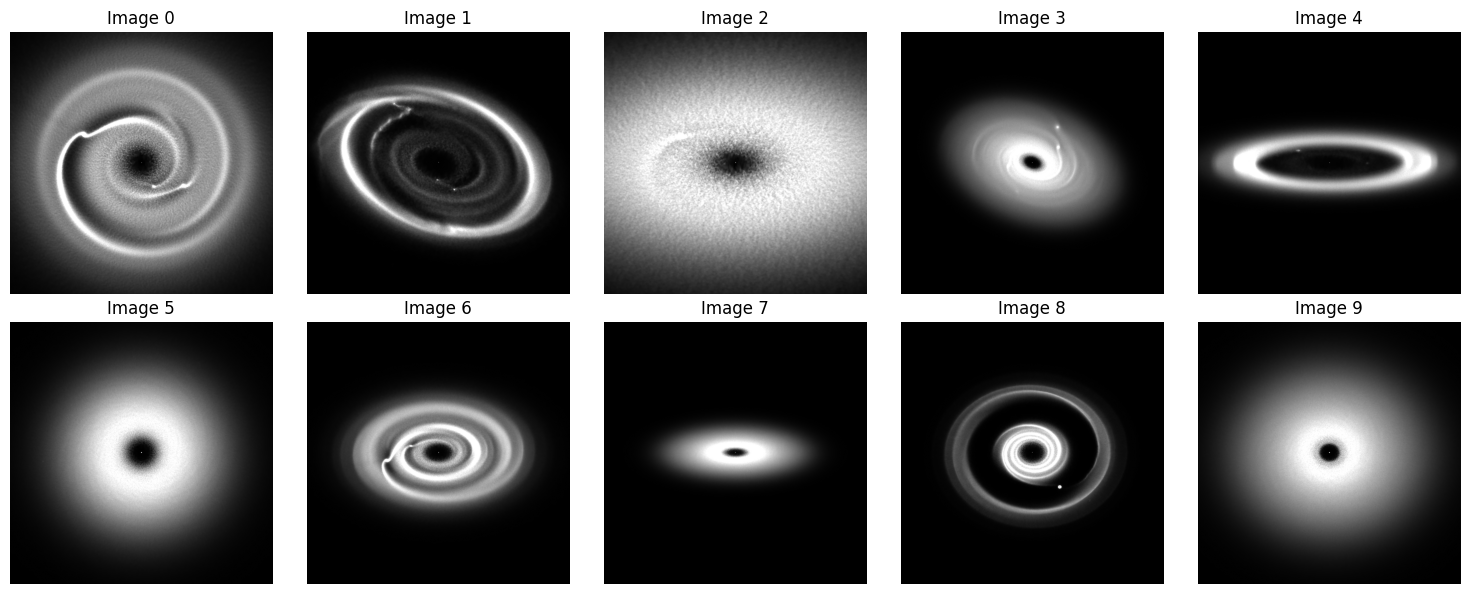

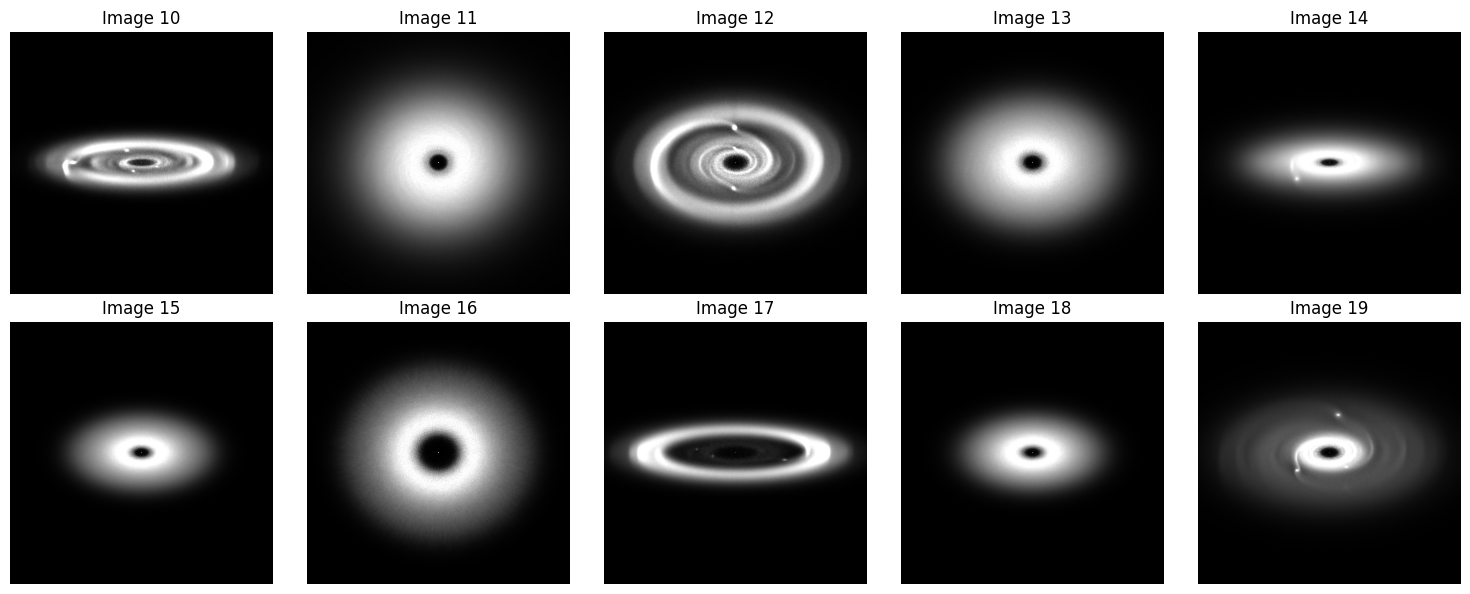

In [9]:
# Visualize page 1 (images 0–9)
visualize_page(dataset_array, page=1)

# Visualize page 2 (images 10–19)
visualize_page(dataset_array, page=2)

# ... up to page 15 (images 140–149)


## Model Testing and Selection  

Several encoder architectures were tested to identify the most suitable model for this dataset:  

- **EfficientNet**  
- **RegNet**  
- **DeiT (Data-efficient Image Transformer)**  
- **MobileViT**  

### Observations  

The dataset was observed to perform **better on attention-based models** (such as DeiT and MobileViT), likely due to:  

- **High structural consistency** across images.  
- **Subtle features** in examples requiring fine-grained feature extraction.  

### Final Model Choice  

After extensive testing, a **modified version of MobileViT-XS** was selected as the optimal model, mostly due to computation speed. This architecture was adapted from the implementation found [here](https://github.com/chinhsuanwu/mobilevit-pytorch).  

### Key Modifications & Findings  

- A **patch size of 2** was found to work best, preserving spatial details while ensuring effective tokenization.  
  


In [10]:
# MOBILE VIT MODEL

def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


def conv_nxn_bn(inp, oup, kernal_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernal_size, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b p n (h d) -> b p h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class MV2Block(nn.Module):
    def __init__(self, inp, oup, stride=1, expansion=4):
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expansion)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)

        self.transformer = Transformer(dim, depth, 4, 8, mlp_dim, dropout)

        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)

    def forward(self, x):
        y = x.clone()

        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)

        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d', ph=self.ph, pw=self.pw)
        x = self.transformer(x)
        x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)', h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)

        # Fusion
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x


class MobileViT(nn.Module):
    def __init__(self, image_size, dims, channels, num_classes, expansion=4, kernel_size=3, patch_size=(2, 2)):
        super().__init__()
        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        L = [2, 4, 3]

        self.conv1 = conv_nxn_bn(1, channels[0], stride=2)

        self.mv2 = nn.ModuleList([])
        self.mv2.append(MV2Block(channels[0], channels[1], 1, expansion))
        self.mv2.append(MV2Block(channels[1], channels[2], 2, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))
        self.mv2.append(MV2Block(channels[2], channels[3], 1, expansion))   # Repeat
        self.mv2.append(MV2Block(channels[3], channels[4], 2, expansion))
        self.mv2.append(MV2Block(channels[5], channels[6], 2, expansion))
        self.mv2.append(MV2Block(channels[7], channels[8], 2, expansion))

        self.mvit = nn.ModuleList([])
        self.mvit.append(MobileViTBlock(dims[0], L[0], channels[5], kernel_size, patch_size, int(dims[0]*2)))
        self.mvit.append(MobileViTBlock(dims[1], L[1], channels[7], kernel_size, patch_size, int(dims[1]*4)))
        self.mvit.append(MobileViTBlock(dims[2], L[2], channels[9], kernel_size, patch_size, int(dims[2]*4)))

        self.conv2 = conv_1x1_bn(channels[-2], channels[-1])

        self.pool = nn.AvgPool2d(ih//32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mv2[0](x)

        x = self.mv2[1](x)
        x = self.mv2[2](x)
        x = self.mv2[3](x)      # Repeat

        x = self.mv2[4](x)
        x = self.mvit[0](x)

        x = self.mv2[5](x)
        x = self.mvit[1](x)

        x = self.mv2[6](x)
        x = self.mvit[2](x)
        x = self.conv2(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x

# Example model instantiation for hyperspectral input
def mobilevit():
    dims = [64, 80, 96]
    channels = [16, 16, 24, 24, 48, 48, 64, 64, 80, 80, 320]
    return MobileViT((512, 512), dims, channels, num_classes=16, expansion=2)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def init_weights_kaiming(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Testing
if __name__ == '__main__':
    img = torch.randn(11, 1, 512, 512)

    model = mobilevit()
    out = model(img)
    print(out.shape)
    print(count_parameters(model))


torch.Size([11, 16])
1016304


In [11]:
# TRANSFORM CLASS

def zoom_image(image, zoom_range=(0.8, 1.2), zoom_in_prob=0.5):
    """
    Randomly zoom in or out of a grayscale PIL image while preserving dimensions,
    pixel value types, and image mode.

    Args:
        image (PIL.Image): Grayscale image ('L' or float mode).
        zoom_range (tuple): Min and max zoom factors.
        zoom_in_prob (float): Probability of zooming in vs out.

    Returns:
        PIL.Image: Zoomed image with original dimensions and mode.
    """
    assert image.mode in ('L', 'F'), "Expected grayscale image in mode 'L' or 'F'"
    width, height = image.size
    zoom_in = random.random() < zoom_in_prob
    factor = random.uniform(*zoom_range)

    # Zoom in (crop and resize back)
    if zoom_in and factor > 1.0:
        new_w, new_h = int(width / factor), int(height / factor)
        left = (width - new_w) // 2
        top = (height - new_h) // 2
        cropped = image.crop((left, top, left + new_w, top + new_h))
        image = cropped.resize((width, height), Image.BICUBIC)

    # Zoom out (shrink and pad back)
    elif not zoom_in and factor < 1.0:
        new_w, new_h = int(width * factor), int(height * factor)
        shrunk = image.resize((new_w, new_h), Image.BICUBIC)
        if image.mode == 'F':
            background = Image.new('F', (width, height), 0.0)
        else:
            background = Image.new('L', (width, height), 0)
        left = (width - new_w) // 2
        top = (height - new_h) // 2
        background.paste(shrunk, (left, top))
        image = background

    return image



class VerticalSqueezePadRotate:
    def __init__(self, squeeze_factor=0.5, rotate_angle=0, p=1.0, rotate_flip_p=0.5):
        """
        squeeze_factor: Fraction to resize along vertical axis (0 < factor <= 1).
        rotate_angle: Angle in degrees to rotate counterclockwise after resizing and padding.
        p: Overall probability of applying the transform.
        rotate_flip_p: Probability of applying both rotate and horizontal flip (must occur together).
        """
        assert 0 < squeeze_factor <= 1, "squeeze_factor must be between 0 and 1"
        self.squeeze_factor = squeeze_factor
        self.rotate_angle = rotate_angle
        self.p = p
        self.rotate_flip_p = rotate_flip_p

    def __call__(self, img):
        if np.random.rand() > self.p:
            return img

        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)

        w, h = img.size
        new_h = int(h * self.squeeze_factor)

        # Step 1: Resize vertically
        img_resized = img.resize((w, new_h), resample=Image.BILINEAR)
        #img_resized = np.array(img_resized)

        # Step 2: Pad equally on top and bottom to restore original height
        pad_total = h - new_h
        pad_top = pad_total // 2
        pad_bottom = pad_total - pad_top
        img_padded = ImageOps.expand(img_resized, border=(0, pad_top, 0, pad_bottom), fill=0)
        img_padded = F.rotate(img_padded, angle=3,
                                      interpolation=InterpolationMode.BILINEAR, fill=0)

        # Step 3: Apply rotation and flip together with rotate_flip_p probability
        if np.random.rand() < self.rotate_flip_p:
            if self.rotate_angle != 0:
                img_padded = F.rotate(img_padded, angle=self.rotate_angle,
                                      interpolation=InterpolationMode.BILINEAR, fill=0)
            img_padded = F.hflip(img_padded)

        img_padded = zoom_image(img_padded, zoom_range=(0.8, 1.2), zoom_in_prob=0.5)

        return np.array(img_padded)


# Dataset Transformation for Deep Unsupervised Clustering

## Objective

The primary goal of the data transformation pipeline was to enable **effective unsupervised clustering** while avoiding the pitfall of **clustering based on differing images** of the same semantic meaning. Instead, the transformation encourages the model to learn **view-invariant representations**, clustering based on intrinsic semantic structure rather than superficial appearance.

---

## 1. View-Invariant Augmentation Strategy

In unsupervised clustering, a common challenge is the tendency of models to cluster different augmented views of the same image into separate clusters. To mitigate this, a carefully designed augmentation pipeline was implemented to create **alternative views** of the same image that preserve underlying structure while varying appearance:

### Augmentation Techniques Used:
- **Squeeze & Pad**: Adjusts the image aspect ratio to simulate different spatial configurations.
- **Rotation**: Introduces angular variation to challenge the model’s orientation invariance.
- **Resize**: Uniformly scales images to maintain consistent dimensions without biasing cluster assignments.

### Purpose:
These augmentations encourage the model to **treat both the original and its augmented view as the same underlying instance**, thus forcing the clustering algorithm to **group semantically similar representations** regardless of capture angle.

---

## 2. Preprocessing for Outlier Mitigation

During analysis, it was observed that the dataset contained **extreme outliers** in pixel intensity values, negatively impacting image visibility and learning stability.

### Remediation Steps:

#### a. **Truncation at 99th Percentile**
- Pixel values were clipped at the 99th percentile.
- This suppressed extreme outliers that distorted overall intensity distribution.

#### b. **Adaptive Histogram Equalization**
- Applied to enhance local contrast and improve visibility across the dataset.
- Resulted in:
  - **More evenly distributed brightness** across samples.
  - **Improved feature visibility**, especially in subtle or low-contrast regions.
  - **Faster convergence** and **better performance** during training due to more consistent input quality.

---



The transformation pipeline is designed to **normalize image quality**, **enhance feature visibility**, and **enforce view-invariant learning**, making it highly suitable for unsupervised clustering. By addressing both augmentation semantics and data distribution issues, the pipeline significantly improves the model’s ability to discover meaningful clusters based on the true content of the images.


In [12]:
# DATASET CLASS

class DualTransformDataset(Dataset):
    def __init__(self, numpy_array,clip_limit=(0, 99), transform=None):
        """
        Args:
            numpy_array (np.ndarray): Input dataset of shape (N, 600, 600)
            transform (callable, optional): Transform to apply to one copy of each image
        """
        assert isinstance(numpy_array, np.ndarray), "Input must be a NumPy array"
        assert numpy_array.ndim == 3, "Input must be of shape (N, H, W)"
        self.data = numpy_array
        self.transform = transform
        self.clip_limit = clip_limit

        self.resize = T.Resize((512, 512), interpolation=T.InterpolationMode.BILINEAR)
        self.to_tensor = T.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_np = self.data[idx]  # Shape: (600, 600)
        img_np = adaptive_brightness(img_np, clip_limit=self.clip_limit)

        if self.transform:
            img_transformed = self.transform(img_np)
        else:
            img_transformed = img_np.copy()

        img_tensor = torch.from_numpy(img_transformed).unsqueeze(0)  # Ensure tensor format
        img_tensor_original = torch.from_numpy(img_np).unsqueeze(0)

        img_tensor = self.resize(img_tensor)
        img_tensor_original = self.resize(img_tensor_original)

        return img_tensor_original, img_tensor, idx


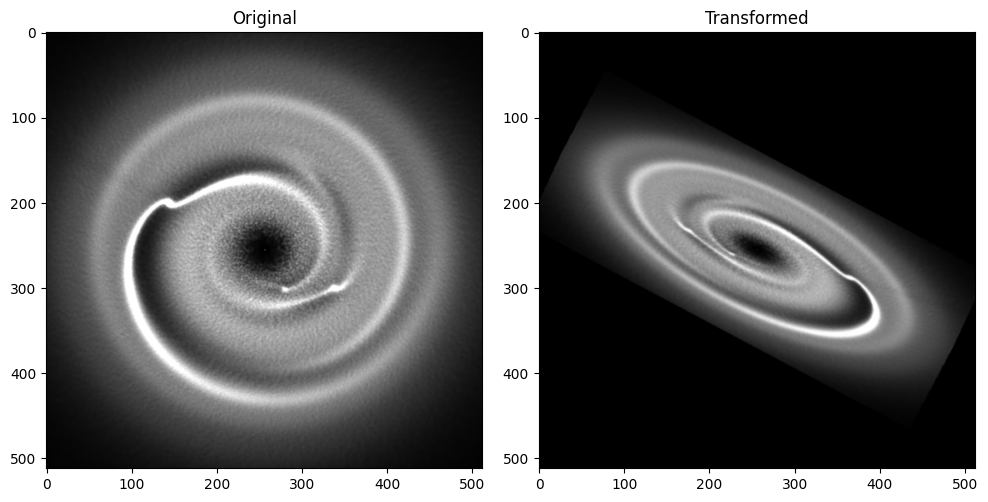

In [13]:
# Load transform and dataset
transform = VerticalSqueezePadRotate(squeeze_factor=0.4, rotate_angle=25, p=1.0, rotate_flip_p=0.5)
dataset = DualTransformDataset(dataset_array, transform=transform)

# Check one sample
img_orig, img_t, _ = dataset[0]

# Visualize both
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_orig.squeeze(0), cmap="gray")
ax[0].set_title("Original")

ax[1].imshow(img_t.squeeze(0), cmap="gray")
ax[1].set_title("Transformed")

plt.tight_layout()
plt.show()


# Why SwAV is a Natural Fit for Unsupervised Clustering in This Task

## Alignment with Task Objectives

The SwAV (Swapping Assignments between Views) contrastive learning algorithm is particularly well-suited for this project due to its ability to cluster **multiple views of the same image** together without needing to explicitly contrast against other samples:

- ✅ **View-Invariant Learning**: SwAV encourages the model to assign the **same cluster ID to different augmented views** of the same image.
- ✅ **Avoids Pairwise Negatives**: Unlike SimCLR, SwAV does **not force similar images apart**, which is crucial for this dataset where many samples are semantically close.
- ✅ **Preserves Semantic Consistency**: The strategy fits perfectly with our augmentation scheme, which presents alternate views (squeeze, pad, rotate, resize) of the same image to guide the model toward structure-aware clustering.

---

## Technical Summary of SwAV

SwAV is a self-supervised learning algorithm based on **online clustering of representations**:

1. **Two Augmented Views**: The same image is passed through two different augmentations.
2. **Shared Encoder**: Both views are encoded using the same feature extractor.
3. **Prototypes (Centroids)**: The encoded features are softly assigned to a fixed set of **learnable prototype vectors** using a Sinkhorn-Knopp algorithm.
4. **Swapped Prediction**: Each view is used to **predict the cluster assignment** of the other — hence the name “Swapping Assignments between Views.”

This design allows the model to learn **discriminative and semantically meaningful features** without using labeled data or negative pairs.

---

## Advantages of Using SwAV

- ⚡ **Computational Efficiency**: SwAV avoids the heavy compute cost of contrastive pair mining and negative sampling.
- 📦 **Scalable to Small and Large Batch Sizes**: Unlike SimCLR, which relies on large batches for performance, SwAV maintains stability across a wide range of batch sizes.
- 🧠 **Integrated Clustering**: By jointly optimizing clustering and representation learning, SwAV reduces the need for a separate clustering stage.
- 🔁 **No Momentum Encoder Required**: Simplifies training setup compared to methods like MoCo.

---

## Planned Training Strategy

To explore the structure of the dataset at different granularities, the model will be trained using SwAV with the following clustering configurations:

- **2 Clusters** – Coarse grouping for binary structure separation.
- **3 Clusters** – Intermediate complexity to capture finer substructures.
- **4 Clusters** – For detailed semantic distinction.

This multi-level clustering strategy will help analyze how the model discovers and organizes latent structure in the data.

---

## Conclusion

SwAV’s strengths in **view-invariant clustering**, **efficient training**, and **adaptability to various batch sizes** make it an ideal fit for this unsupervised clustering project. Combined with the carefully designed augmentation pipeline, SwAV is expected to yield high-quality, semantically meaningful groupings of the lensing images.


In [18]:
# TRAIN PIPELINE

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_IMAGES = 150
IMG_SIZE = 512
BATCH_SIZE = 4
EPOCHS = 100
NUM_PROTOTYPES = 3
EMBED_DIM = 16
TEMPERATURE = 0.2


loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- 3. Prototype Layer
class Prototypes(nn.Module):
    def __init__(self, num_prototypes, feat_dim):
        super().__init__()
        self.prototypes = nn.Linear(feat_dim, num_prototypes, bias=False)

    def forward(self, x):
        return Func.normalize(self.prototypes.weight.data, dim=1), self.prototypes(x)

# --- 4. SwAV Loss
def swav_loss(z1, z2, prototypes, temperature=TEMPERATURE):
    # Normalize embeddings
    z1 = Func.normalize(z1, dim=1)
    z2 = Func.normalize(z2, dim=1)

    with torch.no_grad():
        # Sinkhorn-Knopp for soft assignments
        def sinkhorn(Q, n_iter=3):
            Q = torch.exp(Q / temperature).t()
            Q /= Q.sum()
            K, B = Q.shape
            for _ in range(n_iter):
                Q /= Q.sum(dim=1, keepdim=True)
                Q /= Q.sum(dim=0, keepdim=True)
            return (Q * B).t()

        assign1 = sinkhorn(prototypes(z1)[1])
        assign2 = sinkhorn(prototypes(z2)[1])

    logits1 = prototypes(z2)[1] / temperature
    logits2 = prototypes(z1)[1] / temperature

    loss1 = -torch.sum(assign1 * Func.log_softmax(logits1, dim=1), dim=1).mean()
    loss2 = -torch.sum(assign2 * Func.log_softmax(logits2, dim=1), dim=1).mean()
    return (loss1 + loss2) / 2

# --- 5. Training
def train():
    encoder = mobilevit().to(DEVICE)
    encoder.apply(init_weights_kaiming)
    prototypes = Prototypes(NUM_PROTOTYPES, EMBED_DIM).to(DEVICE)
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(prototypes.parameters()), lr=3e-4)

    print("Starting training...")
    for epoch in range(EPOCHS):
        encoder.train()
        total_loss = 0
        for v1, v2, _ in tqdm(loader, desc=f"Epoch {epoch+1}"):
            v1, v2 = v1.to(DEVICE), v2.to(DEVICE)
            z1 = encoder(v1)
            z2 = encoder(v2)
            loss = swav_loss(z1, z2, prototypes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {total_loss / len(loader):.4f}")

    # --- 5. Visualization
    print("Extracting embeddings for visualization...")
    all_imgs, all_feats, all_indices = [], [], []

    encoder.eval()
    with torch.no_grad():
        for v1, _, idx in loader:  # capture index from DataLoader
            v1 = v1.to(DEVICE)
            feats = encoder(v1)
            all_feats.append(feats.cpu())
            all_imgs.append(v1.cpu())
            all_indices.append(idx)  # save the indices

    all_feats = torch.cat(all_feats)
    all_imgs = torch.cat(all_imgs)
    all_indices = torch.cat(all_indices)  # [N] tensor of indices

    # Reduce dimensions with PCA
    pca = PCA(n_components=2)
    feat_2d = pca.fit_transform(all_feats.numpy())

    # Cluster with KMeans
    kmeans = KMeans(n_clusters=NUM_PROTOTYPES, n_init=10)
    labels = kmeans.fit_predict(feat_2d)

    # Plot images grouped by cluster
    def plot_clustered_images(images, labels, num_clusters):
        fig, axes = plt.subplots(num_clusters, 10, figsize=(15, 1.5 * num_clusters))
        for i in range(num_clusters):
            cluster_imgs = images[labels == i][:10]
            for j, img in enumerate(cluster_imgs):
                axes[i, j].imshow(img.squeeze(), cmap="gray")
                axes[i, j].axis('off')
            for j in range(len(cluster_imgs), 10):
                axes[i, j].axis('off')
        plt.tight_layout()
        plt.show()

    plot_clustered_images(all_imgs, labels, NUM_PROTOTYPES)

    # 🔍 Print list of files for each cluster
    cluster_to_files = {i: [] for i in range(NUM_PROTOTYPES)}
    for cluster_label, file_idx in zip(labels, all_indices.numpy()):
        cluster_to_files[cluster_label].append(fits_files[file_idx])

    print("\n--- Files grouped by cluster ---")
    for cluster_id, files in cluster_to_files.items():
        print(f"\nCluster {cluster_id} ({len(files)} images):")
        for fname in files:
            print(" ", fname)


Starting training...


Epoch 1: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 1 Loss: 2.7342


Epoch 2: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


Epoch 2 Loss: 2.7381


Epoch 3: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


Epoch 3 Loss: 2.7381


Epoch 4: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


Epoch 4 Loss: 2.7367


Epoch 5: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 5 Loss: 2.7367


Epoch 6: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


Epoch 6 Loss: 2.7371


Epoch 7: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 7 Loss: 2.7366


Epoch 8: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 8 Loss: 2.7365


Epoch 9: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 9 Loss: 2.7366


Epoch 10: 100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


Epoch 10 Loss: 2.7367


Epoch 11: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


Epoch 11 Loss: 2.7365


Epoch 12: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 12 Loss: 2.7365


Epoch 13: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 13 Loss: 2.7360


Epoch 14: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 14 Loss: 2.7365


Epoch 15: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 15 Loss: 2.7364


Epoch 16: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 16 Loss: 2.7363


Epoch 17: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 17 Loss: 2.7363


Epoch 18: 100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


Epoch 18 Loss: 2.7363


Epoch 19: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 19 Loss: 2.7363


Epoch 20: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 20 Loss: 2.7363


Epoch 21: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 21 Loss: 2.7364


Epoch 22: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 22 Loss: 2.7363


Epoch 23: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 23 Loss: 2.7362


Epoch 24: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


Epoch 24 Loss: 2.7362


Epoch 25: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


Epoch 25 Loss: 2.7362


Epoch 26: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 26 Loss: 2.7362


Epoch 27: 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


Epoch 27 Loss: 2.7363


Epoch 28: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 28 Loss: 2.7362


Epoch 29: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 29 Loss: 2.7362


Epoch 30: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 30 Loss: 2.7363


Epoch 31: 100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


Epoch 31 Loss: 2.7362


Epoch 32: 100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


Epoch 32 Loss: 2.7361


Epoch 33: 100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


Epoch 33 Loss: 2.7362


Epoch 34: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


Epoch 34 Loss: 2.7362


Epoch 35: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


Epoch 35 Loss: 2.7362


Epoch 36: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 36 Loss: 2.7361


Epoch 37: 100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


Epoch 37 Loss: 2.7361


Epoch 38: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


Epoch 38 Loss: 2.7361


Epoch 39: 100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


Epoch 39 Loss: 2.7362


Epoch 40: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 40 Loss: 2.7360


Epoch 41: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 41 Loss: 2.7362


Epoch 42: 100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


Epoch 42 Loss: 2.7362


Epoch 43: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 43 Loss: 2.7362


Epoch 44: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 44 Loss: 2.7362


Epoch 45: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 45 Loss: 2.7362


Epoch 46: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


Epoch 46 Loss: 2.7362


Epoch 47: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 47 Loss: 2.7362


Epoch 48: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 48 Loss: 2.7362


Epoch 49: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 49 Loss: 2.7361


Epoch 50: 100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


Epoch 50 Loss: 2.7362


Epoch 51: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 51 Loss: 2.7362


Epoch 52: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 52 Loss: 2.7361


Epoch 53: 100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


Epoch 53 Loss: 2.7361


Epoch 54: 100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


Epoch 54 Loss: 2.7361


Epoch 55: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 55 Loss: 2.7361


Epoch 56: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 56 Loss: 2.7361


Epoch 57: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 57 Loss: 2.7362


Epoch 58: 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


Epoch 58 Loss: 2.7361


Epoch 59: 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


Epoch 59 Loss: 2.7361


Epoch 60: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


Epoch 60 Loss: 2.7362


Epoch 61: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


Epoch 61 Loss: 2.7361


Epoch 62: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 62 Loss: 2.7362


Epoch 63: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 63 Loss: 2.7361


Epoch 64: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 64 Loss: 2.7361


Epoch 65: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 65 Loss: 2.7361


Epoch 66: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 66 Loss: 2.7361


Epoch 67: 100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


Epoch 67 Loss: 2.7361


Epoch 68: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


Epoch 68 Loss: 2.7361


Epoch 69: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 69 Loss: 2.7362


Epoch 70: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 70 Loss: 2.7362


Epoch 71: 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


Epoch 71 Loss: 2.7361


Epoch 72: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 72 Loss: 2.7361


Epoch 73: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 73 Loss: 2.7362


Epoch 74: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 74 Loss: 2.7361


Epoch 75: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


Epoch 75 Loss: 2.7362


Epoch 76: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 76 Loss: 2.7361


Epoch 77: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 77 Loss: 2.7361


Epoch 78: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 78 Loss: 2.7361


Epoch 79: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 79 Loss: 2.7361


Epoch 80: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 80 Loss: 2.7361


Epoch 81: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 81 Loss: 2.7361


Epoch 82: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


Epoch 82 Loss: 2.7361


Epoch 83: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 83 Loss: 2.7361


Epoch 84: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 84 Loss: 2.7361


Epoch 85: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 85 Loss: 2.7361


Epoch 86: 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


Epoch 86 Loss: 2.7361


Epoch 87: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 87 Loss: 2.7361


Epoch 88: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 88 Loss: 2.7361


Epoch 89: 100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


Epoch 89 Loss: 2.7361


Epoch 90: 100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


Epoch 90 Loss: 2.7361


Epoch 91: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 91 Loss: 2.7361


Epoch 92: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 92 Loss: 2.7361


Epoch 93: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 93 Loss: 2.7361


Epoch 94: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 94 Loss: 2.7361


Epoch 95: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 95 Loss: 2.7361


Epoch 96: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


Epoch 96 Loss: 2.7361


Epoch 97: 100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


Epoch 97 Loss: 2.7361


Epoch 98: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 98 Loss: 2.7361


Epoch 99: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 99 Loss: 2.7361


Epoch 100: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 100 Loss: 2.7361
Extracting embeddings for visualization...


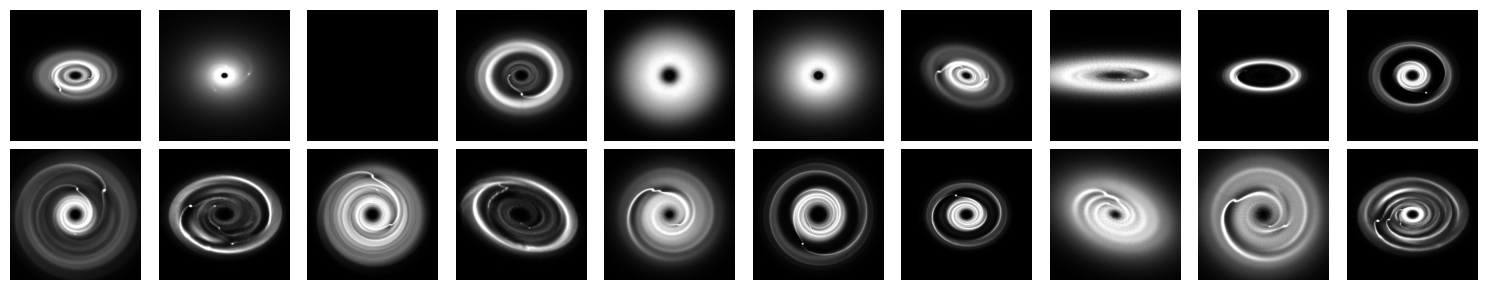


--- Files grouped by cluster ---

Cluster 0 (133 images):
  planet68_00640_1250.fits
  planet21_00282_1250.fits
  planet13_00302_1250.fits
  planet41_00784_1250.fits
  planet33_00310_1250.fits
  planet8_00320_1250.fits
  planet40_00352_1250.fits
  planet103_00718_1250.fits
  planet7_00730_1250.fits
  planet5_00882_1250.fits
  planet68_00920_1250.fits
  planet6_00638_1250.fits
  planet26_00764_1250.fits
  planet102_00222_1250.fits
  planet33_00102_1250.fits
  planet20_00230_1250.fits
  planet3_00078_1250.fits
  planet32_00676_1250.fits
  planet23_00310_1250.fits
  planet72_00164_1250.fits
  planet4_00442_1250.fits
  planet30_00510_1250.fits
  planet88_00674_1250.fits
  planet26_00912_1250.fits
  planet28_00612_1250.fits
  planet6_00566_1250.fits
  planet51_00842_1250.fits
  planet14_00914_1250.fits
  planet29_00518_1250.fits
  planet35_00114_1250.fits
  planet10_00816_1250.fits
  planet100_00580_1250.fits
  planet8_00100_1250.fits
  planet48_00468_1250.fits
  planet2_00548_1250.fits
  

In [19]:
NUM_PROTOTYPES = 2
train()

Starting training...


Epoch 1: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 1 Loss: 4.2612


Epoch 2: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 2 Loss: 4.3308


Epoch 3: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 3 Loss: 4.3363


Epoch 4: 100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


Epoch 4 Loss: 4.3369


Epoch 5: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


Epoch 5 Loss: 4.3367


Epoch 6: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 6 Loss: 4.3364


Epoch 7: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 7 Loss: 4.3363


Epoch 8: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 8 Loss: 4.3363


Epoch 9: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


Epoch 9 Loss: 4.3368


Epoch 10: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


Epoch 10 Loss: 4.3362


Epoch 11: 100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


Epoch 11 Loss: 4.3355


Epoch 12: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


Epoch 12 Loss: 4.3365


Epoch 13: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


Epoch 13 Loss: 4.3365


Epoch 14: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 14 Loss: 4.3365


Epoch 15: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 15 Loss: 4.3358


Epoch 16: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


Epoch 16 Loss: 4.3365


Epoch 17: 100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


Epoch 17 Loss: 4.3364


Epoch 18: 100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


Epoch 18 Loss: 4.3368


Epoch 19: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 19 Loss: 4.3363


Epoch 20: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 20 Loss: 4.3366


Epoch 21: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 21 Loss: 4.3365


Epoch 22: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 22 Loss: 4.3366


Epoch 23: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 23 Loss: 4.3366


Epoch 24: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 24 Loss: 4.3366


Epoch 25: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


Epoch 25 Loss: 4.3365


Epoch 26: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


Epoch 26 Loss: 4.3365


Epoch 27: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 27 Loss: 4.3367


Epoch 28: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 28 Loss: 4.3367


Epoch 29: 100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


Epoch 29 Loss: 4.3352


Epoch 30: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 30 Loss: 4.3365


Epoch 31: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 31 Loss: 4.3364


Epoch 32: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


Epoch 32 Loss: 4.3351


Epoch 33: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


Epoch 33 Loss: 4.3365


Epoch 34: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 34 Loss: 4.3365


Epoch 35: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 35 Loss: 4.3365


Epoch 36: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 36 Loss: 4.3366


Epoch 37: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 37 Loss: 4.3365


Epoch 38: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 38 Loss: 4.3366


Epoch 39: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


Epoch 39 Loss: 4.3365


Epoch 40: 100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


Epoch 40 Loss: 4.3364


Epoch 41: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 41 Loss: 4.3366


Epoch 42: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 42 Loss: 4.3359


Epoch 43: 100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


Epoch 43 Loss: 4.3315


Epoch 44: 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


Epoch 44 Loss: 4.3364


Epoch 45: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 45 Loss: 4.3365


Epoch 46: 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


Epoch 46 Loss: 4.3366


Epoch 47: 100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


Epoch 47 Loss: 4.3366


Epoch 48: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 48 Loss: 4.3366


Epoch 49: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 49 Loss: 4.3366


Epoch 50: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 50 Loss: 4.3363


Epoch 51: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 51 Loss: 4.3365


Epoch 52: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 52 Loss: 4.3366


Epoch 53: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 53 Loss: 4.3366


Epoch 54: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


Epoch 54 Loss: 4.3365


Epoch 55: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


Epoch 55 Loss: 4.3365


Epoch 56: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 56 Loss: 4.3366


Epoch 57: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 57 Loss: 4.3366


Epoch 58: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 58 Loss: 4.3366


Epoch 59: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 59 Loss: 4.3366


Epoch 60: 100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


Epoch 60 Loss: 4.3366


Epoch 61: 100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


Epoch 61 Loss: 4.3366


Epoch 62: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


Epoch 62 Loss: 4.3364


Epoch 63: 100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


Epoch 63 Loss: 4.3365


Epoch 64: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 64 Loss: 4.3365


Epoch 65: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 65 Loss: 4.3366


Epoch 66: 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


Epoch 66 Loss: 4.3366


Epoch 67: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 67 Loss: 4.3366


Epoch 68: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 68 Loss: 4.3365


Epoch 69: 100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


Epoch 69 Loss: 4.3358


Epoch 70: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 70 Loss: 4.3363


Epoch 71: 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


Epoch 71 Loss: 4.3366


Epoch 72: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 72 Loss: 4.3366


Epoch 73: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 73 Loss: 4.3366


Epoch 74: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 74 Loss: 4.3366


Epoch 75: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 75 Loss: 4.3366


Epoch 76: 100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


Epoch 76 Loss: 4.3364


Epoch 77: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 77 Loss: 4.3361


Epoch 78: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 78 Loss: 4.3364


Epoch 79: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 79 Loss: 4.3364


Epoch 80: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 80 Loss: 4.3365


Epoch 81: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 81 Loss: 4.3366


Epoch 82: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 82 Loss: 4.3366


Epoch 83: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


Epoch 83 Loss: 4.3366


Epoch 84: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 84 Loss: 4.3366


Epoch 85: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 85 Loss: 4.3366


Epoch 86: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 86 Loss: 4.3366


Epoch 87: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 87 Loss: 4.3366


Epoch 88: 100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


Epoch 88 Loss: 4.3366


Epoch 89: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 89 Loss: 4.3366


Epoch 90: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 90 Loss: 4.3365


Epoch 91: 100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


Epoch 91 Loss: 4.3366


Epoch 92: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 92 Loss: 4.3366


Epoch 93: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 93 Loss: 4.3366


Epoch 94: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 94 Loss: 4.3366


Epoch 95: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 95 Loss: 4.3366


Epoch 96: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 96 Loss: 4.3366


Epoch 97: 100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


Epoch 97 Loss: 4.3365


Epoch 98: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


Epoch 98 Loss: 4.3366


Epoch 99: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 99 Loss: 4.3366


Epoch 100: 100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


Epoch 100 Loss: 4.3366
Extracting embeddings for visualization...


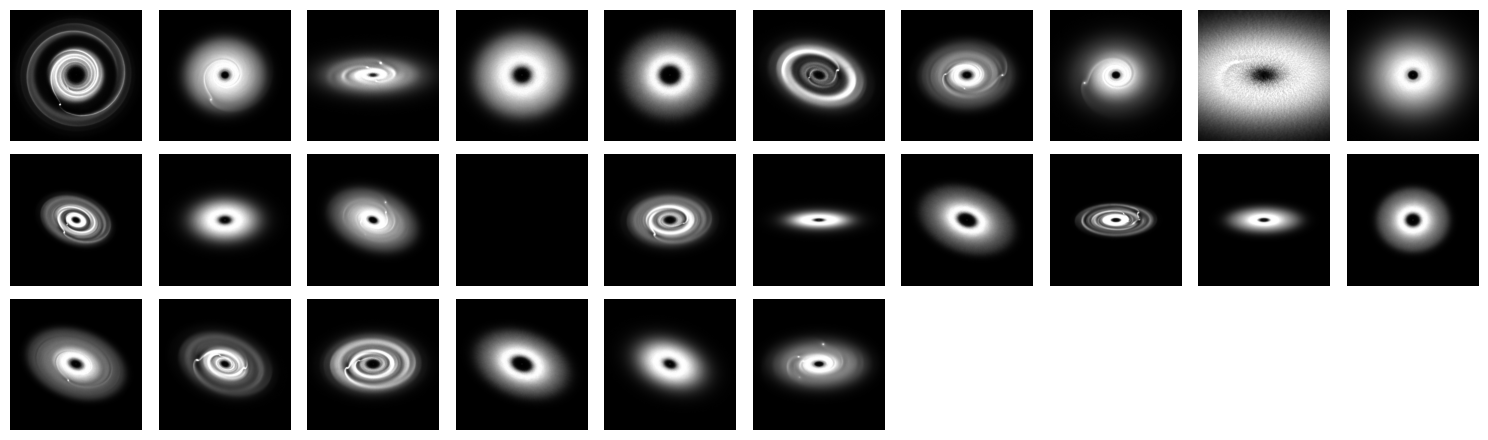


--- Files grouped by cluster ---

Cluster 0 (69 images):
  planet45_00886_1250.fits
  planet38_00100_1250.fits
  planet20_00230_1250.fits
  planet99_00400_1250.fits
  planet6_00566_1250.fits
  planet41_00734_1250.fits
  planet15_00186_1250.fits
  planet44_00346_1250.fits
  planet1_00490_1250.fits
  planet8_00214_1250.fits
  planet32_00676_1250.fits
  planet24_00394_1250.fits
  planet102_00346_1250.fits
  planet33_00310_1250.fits
  planet103_00718_1250.fits
  planet17_00506_1250.fits
  planet38_00980_1250.fits
  planet2_00154_1250.fits
  planet18_00992_1250.fits
  planet41_00576_1250.fits
  planet28_00914_1250.fits
  planet38_00948_1250.fits
  planet64_00624_1250.fits
  planet6_00704_1250.fits
  planet44_00308_1250.fits
  planet48_00154_1250.fits
  planet20_00336_1250.fits
  planet2_00308_1250.fits
  planet40_00648_1250.fits
  planet43_00358_1250.fits
  planet45_00952_1250.fits
  planet30_00510_1250.fits
  planet41_00784_1250.fits
  planet102_00230_1250.fits
  planet60_00344_1250.fits


In [20]:
NUM_PROTOTYPES = 3
train()

Starting training...


Epoch 1: 100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


Epoch 1 Loss: 5.3981


Epoch 2: 100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


Epoch 2 Loss: 5.4524


Epoch 3: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 3 Loss: 5.4681


Epoch 4: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 4 Loss: 5.4683


Epoch 5: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 5 Loss: 5.4712


Epoch 6: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 6 Loss: 5.4716


Epoch 7: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 7 Loss: 5.4718


Epoch 8: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 8 Loss: 5.4720


Epoch 9: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


Epoch 9 Loss: 5.4717


Epoch 10: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 10 Loss: 5.4722


Epoch 11: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 11 Loss: 5.4719


Epoch 12: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 12 Loss: 5.4719


Epoch 13: 100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


Epoch 13 Loss: 5.4719


Epoch 14: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 14 Loss: 5.4717


Epoch 15: 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


Epoch 15 Loss: 5.4723


Epoch 16: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


Epoch 16 Loss: 5.4720


Epoch 17: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 17 Loss: 5.4686


Epoch 18: 100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


Epoch 18 Loss: 5.4695


Epoch 19: 100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


Epoch 19 Loss: 5.4719


Epoch 20: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 20 Loss: 5.4685


Epoch 21: 100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


Epoch 21 Loss: 5.4714


Epoch 22: 100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


Epoch 22 Loss: 5.4723


Epoch 23: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 23 Loss: 5.4722


Epoch 24: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 24 Loss: 5.4721


Epoch 25: 100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


Epoch 25 Loss: 5.4722


Epoch 26: 100%|██████████| 38/38 [00:11<00:00,  3.26it/s]


Epoch 26 Loss: 5.4716


Epoch 27: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 27 Loss: 5.4555


Epoch 28: 100%|██████████| 38/38 [00:11<00:00,  3.25it/s]


Epoch 28 Loss: 5.4699


Epoch 29: 100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


Epoch 29 Loss: 5.4714


Epoch 30: 100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


Epoch 30 Loss: 5.4721


Epoch 31: 100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


Epoch 31 Loss: 5.4722


Epoch 32: 100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


Epoch 32 Loss: 5.4722


Epoch 33: 100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


Epoch 33 Loss: 5.4722


Epoch 34: 100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


Epoch 34 Loss: 5.4722


Epoch 35: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 35 Loss: 5.4723


Epoch 36: 100%|██████████| 38/38 [00:11<00:00,  3.26it/s]


Epoch 36 Loss: 5.4722


Epoch 37: 100%|██████████| 38/38 [00:11<00:00,  3.25it/s]


Epoch 37 Loss: 5.4723


Epoch 38: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 38 Loss: 5.4722


Epoch 39: 100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


Epoch 39 Loss: 5.4722


Epoch 40: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 40 Loss: 5.4722


Epoch 41: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 41 Loss: 5.4722


Epoch 42: 100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


Epoch 42 Loss: 5.4722


Epoch 43: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 43 Loss: 5.4722


Epoch 44: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 44 Loss: 5.4722


Epoch 45: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 45 Loss: 5.4722


Epoch 46: 100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


Epoch 46 Loss: 5.4722


Epoch 47: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 47 Loss: 5.4722


Epoch 48: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 48 Loss: 5.4723


Epoch 49: 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


Epoch 49 Loss: 5.4722


Epoch 50: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 50 Loss: 5.4722


Epoch 51: 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


Epoch 51 Loss: 5.4722


Epoch 52: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 52 Loss: 5.4722


Epoch 53: 100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


Epoch 53 Loss: 5.4722


Epoch 54: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 54 Loss: 5.4722


Epoch 55: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 55 Loss: 5.4722


Epoch 56: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 56 Loss: 5.4722


Epoch 57: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 57 Loss: 5.4722


Epoch 58: 100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


Epoch 58 Loss: 5.4722


Epoch 59: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 59 Loss: 5.4722


Epoch 60: 100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


Epoch 60 Loss: 5.4722


Epoch 61: 100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


Epoch 61 Loss: 5.4722


Epoch 62: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 62 Loss: 5.4722


Epoch 63: 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


Epoch 63 Loss: 5.4722


Epoch 64: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 64 Loss: 5.4722


Epoch 65: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 65 Loss: 5.4722


Epoch 66: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 66 Loss: 5.4722


Epoch 67: 100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


Epoch 67 Loss: 5.4722


Epoch 68: 100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


Epoch 68 Loss: 5.4722


Epoch 69: 100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


Epoch 69 Loss: 5.4722


Epoch 70: 100%|██████████| 38/38 [00:11<00:00,  3.26it/s]


Epoch 70 Loss: 5.4722


Epoch 71: 100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


Epoch 71 Loss: 5.4722


Epoch 72: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 72 Loss: 5.4722


Epoch 73: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 73 Loss: 5.4722


Epoch 74: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 74 Loss: 5.4722


Epoch 75: 100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


Epoch 75 Loss: 5.4722


Epoch 76: 100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


Epoch 76 Loss: 5.4722


Epoch 77: 100%|██████████| 38/38 [00:11<00:00,  3.25it/s]


Epoch 77 Loss: 5.4722


Epoch 78: 100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


Epoch 78 Loss: 5.4722


Epoch 79: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 79 Loss: 5.4722


Epoch 80: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 80 Loss: 5.4722


Epoch 81: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 81 Loss: 5.4722


Epoch 82: 100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


Epoch 82 Loss: 5.4722


Epoch 83: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 83 Loss: 5.4722


Epoch 84: 100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


Epoch 84 Loss: 5.4722


Epoch 85: 100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


Epoch 85 Loss: 5.4722


Epoch 86: 100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


Epoch 86 Loss: 5.4722


Epoch 87: 100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


Epoch 87 Loss: 5.4722


Epoch 88: 100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


Epoch 88 Loss: 5.4722


Epoch 89: 100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


Epoch 89 Loss: 5.4722


Epoch 90: 100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


Epoch 90 Loss: 5.4722


Epoch 91: 100%|██████████| 38/38 [00:11<00:00,  3.25it/s]


Epoch 91 Loss: 5.4722


Epoch 92: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 92 Loss: 5.4722


Epoch 93: 100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


Epoch 93 Loss: 5.4722


Epoch 94: 100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


Epoch 94 Loss: 5.4720


Epoch 95: 100%|██████████| 38/38 [00:11<00:00,  3.26it/s]


Epoch 95 Loss: 5.4721


Epoch 96: 100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


Epoch 96 Loss: 5.4722


Epoch 97: 100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


Epoch 97 Loss: 5.4721


Epoch 98: 100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


Epoch 98 Loss: 5.4722


Epoch 99: 100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


Epoch 99 Loss: 5.4722


Epoch 100: 100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


Epoch 100 Loss: 5.4722
Extracting embeddings for visualization...


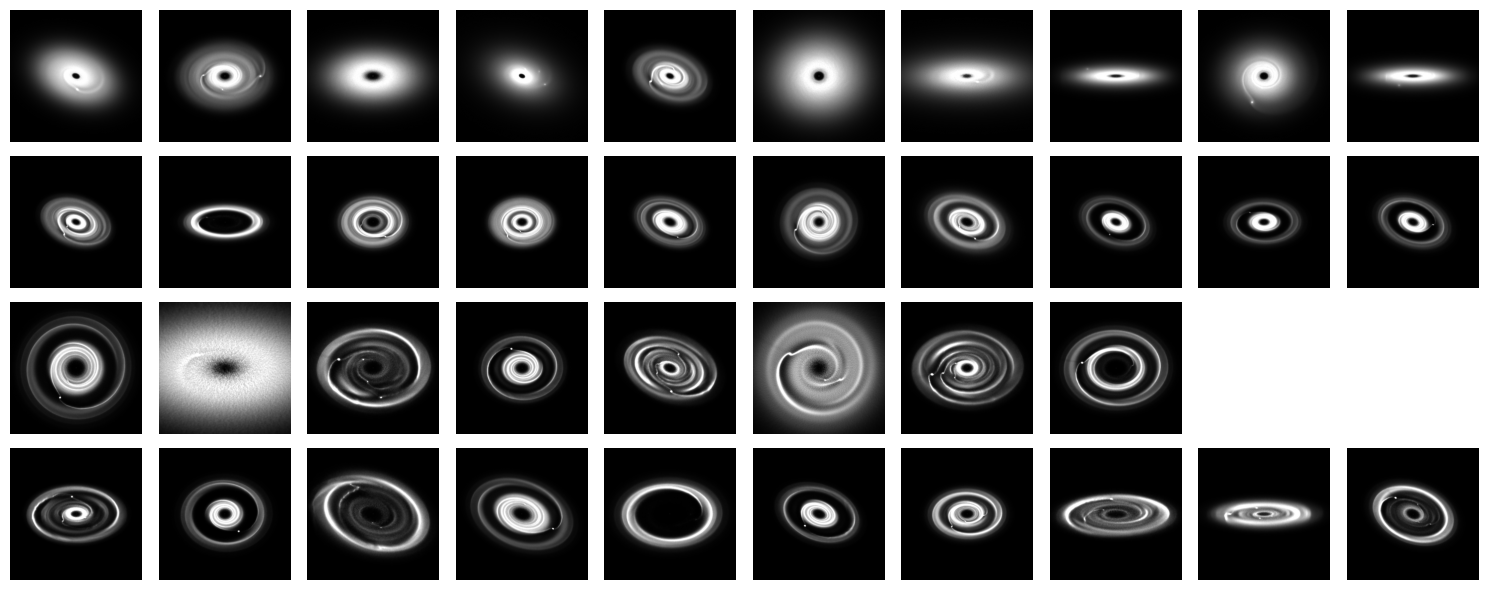


--- Files grouped by cluster ---

Cluster 0 (113 images):
  planet18_00114_1250.fits
  planet15_00186_1250.fits
  planet88_00674_1250.fits
  planet21_00136_1250.fits
  planet0_00226_1250.fits
  planet8_00214_1250.fits
  planet18_00992_1250.fits
  planet55_00320_1250.fits
  planet44_00308_1250.fits
  planet55_00394_1250.fits
  planet40_00370_1250.fits
  planet96_00646_1250.fits
  planet17_00162_1250.fits
  planet2_00154_1250.fits
  planet32_00676_1250.fits
  planet3_00806_1250.fits
  planet80_00754_1250.fits
  planet11_00010_1250.fits
  planet86_00414_1250.fits
  planet13_00098_1250.fits
  planet41_00952_1250.fits
  planet50_00566_1250.fits
  planet2_00548_1250.fits
  planet30_00166_1250.fits
  planet14_00314_1250.fits
  planet2_00708_1250.fits
  planet38_00980_1250.fits
  planet60_00482_1250.fits
  planet48_00468_1250.fits
  planet6_00704_1250.fits
  planet92_00296_1250.fits
  planet86_00120_1250.fits
  planet28_00914_1250.fits
  planet36_00342_1250.fits
  planet96_00808_1250.fits
  p

In [21]:
NUM_PROTOTYPES = 4
train()

### Task 2 Image-Based Test

In [22]:
import torch

def clear_cuda_memory():
  """Clears CUDA memory."""
  torch.cuda.empty_cache()


clear_cuda_memory()

# Using U-Net as an Autoencoder for Task 2

## Why U-Net?

For Task 2, the goal is to encode and reconstruct structured Protoplanetary disk images while preserving a meaningful latent representation for potential downstream tasks such as classification or clustering. The **U-Net architecture** is chosen as an autoencoder due to its **strong spatial encoding-decoding capabilities** and **compact feature learning** properties.

---

## U-Net Architecture Overview

U-Net is a convolutional neural network originally designed for semantic segmentation, but its **encoder–decoder structure** makes it highly suitable for autoencoding tasks as well.

### Key Features:
- **Encoder Path**: A series of convolutional and downsampling layers capture high-level features and compress the spatial dimensions.
- **Decoder Path**: Upsampling layers reconstruct the original image resolution from the compressed latent space.
- **Skip Connections**: Shortcuts between encoder and decoder layers allow recovery of fine-grained spatial information lost during downsampling, improving reconstruction fidelity.

---

## Design Considerations for Task 2

To align with project goals, the U-Net was **redesigned to be lightweight**, resulting in a model with approximately **500,000 parameters**. This has several advantages:

- ⚖️ **Low Computational Cost**: Enables faster training and inference, even on limited hardware.
- 🔍 **Non-Trivial Latent Space**: The bottleneck (neck) of the U-Net captures **compact but meaningful image embeddings**, useful for downstream applications like clustering or classification.
- 🔄 **High-Quality Reconstruction**: Despite its small size, the U-Net maintains strong reconstruction ability due to its symmetric design and skip connections.

---

Unet architecture modifed from reference: https://github.com/Mostafa-wael/U-Net-in-PyTorch/blob/main/U_Net.ipynb

In [23]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # First 3x3 convolutional layer
        self.first = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        # Second 3x3 convolutional layer
        self.second = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        # Apply the two convolution layers and activations
        x = self.first(x)
        x = self.act1(x)
        x = self.second(x)
        return self.act2(x)

class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        # Max pooling layer
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor):
        return self.pool(x)

class UpSample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # Up-convolution
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor):
        return self.up(x)

class CropAndConcat(nn.Module):
    def forward(self, x: torch.Tensor, contracting_x: torch.Tensor):
        # Crop the feature map from the contracting path to the size of the current feature map
        contracting_x = F.center_crop(contracting_x, [x.shape[2], x.shape[3]])
        # Concatenate the feature maps
        x = torch.cat([x, contracting_x], dim=1)
        return x

In [24]:
class UNet(nn.Module):
    def __init__(self, out_channels: int):

        super().__init__()
        # Double convolution layers for the contracting path.
        # The number of features gets doubled at each step starting from 64.
        down_conv_sizes = [(1, 8), (8, 16), (16, 32), (32, 64)]
        self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in down_conv_sizes])

        # Down sampling layers for the contracting path
        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])

        # The two convolution layers at the lowest resolution (the bottom of the U).
        self.middle_conv = DoubleConvolution(64, 128)

        # Up sampling layers for the expansive path.
        # The number of features is halved with up-sampling.
        upsample_sizes = [(128, 64), (64, 32), (32, 16), (16, 8)]

        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in upsample_sizes])
        # Double convolution layers for the expansive path.
        # Their input is the concatenation of the current feature map and the feature map from the
        # contracting path. Therefore, the number of input features is double the number of features
        # from up-sampling.
        up_conv_sizes = [(128, 64), (64, 32), (32, 16), (16, 8)]
        self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in up_conv_sizes])

        # Crop and concatenate layers for the expansive path.
        self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])

        # Final 1x1 convolution layer to produce the output
        self.final_conv = nn.Conv2d(8, out_channels, kernel_size=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # latent compressor
        self.latent_pool = nn.AdaptiveMaxPool2d((1, 1))

    def forward(self, x: torch.Tensor):
        # To collect the outputs of contracting path for later concatenation with the expansive path.
        pass_through = []
        # Contracting path
        for i in range(len(self.down_conv)):
            # Two 3x3 convolutional layers
            x = self.down_conv[i](x)
            # Collect the output
            pass_through.append(x)
            # Down-sample
            x = self.down_sample[i](x)

        # Two 3x3 convolutional layers at the bottom of the U-Net
        x = self.middle_conv(x)
        latent = self.latent_pool(x)

        # Expansive path
        for i in range(len(self.up_conv)):
            # Up-sample
            x = self.up_sample[i](x)
            # Concatenate the output of the contracting path
            x = self.concat[i](x, pass_through.pop())
            # Two 3x3 convolutional layers
            x = self.up_conv[i](x)

        # Final 1x1 convolution layer
        out = self.relu(self.final_conv(x))
        #x = self.final_conv(x)
        #out = (x - x.min()) / (x.max() - x.min())

        return out, latent


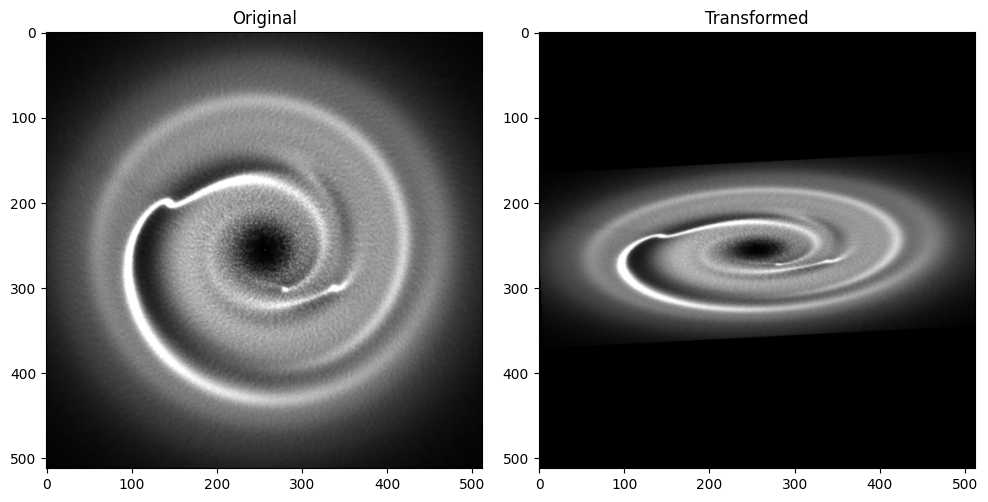

In [25]:
# Load dataset
encoder_dataset = DualTransformDataset(dataset_array, transform=None)

# Check one sample
img_orig, img_t, _ = dataset[0]

# Visualize both
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_orig.squeeze(0), cmap="gray")
ax[0].set_title("Original")

ax[1].imshow(img_t.squeeze(0), cmap="gray")
ax[1].set_title("Transformed")

plt.tight_layout()
plt.show()


In [28]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

train_size = int(0.9 * len(encoder_dataset)) # 90:10 train test split
test_size = len(encoder_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(encoder_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

100%|██████████| 9/9 [00:03<00:00,  2.44it/s]


Epoch 1/20, Loss: 0.042688


 73%|███████▎  | 11/15 [00:00<00:00, 31.98it/s]<ipython-input-29-46de888952f9>:36: RuntimeWarning: divide by zero encountered in log10
  psnr = 20 * np.log10(target.max() / np.sqrt(mse + 1e-10))
100%|██████████| 15/15 [00:00<00:00, 24.31it/s]


New best model saved with SSIM: 0.7873
MSE: 0.036237, PSNR: -inf, SSIM: 0.7873


100%|██████████| 9/9 [00:04<00:00,  2.19it/s]


Epoch 2/20, Loss: 0.021140


100%|██████████| 15/15 [00:00<00:00, 15.84it/s]


New best model saved with SSIM: 0.8607
MSE: 0.013076, PSNR: -inf, SSIM: 0.8607


100%|██████████| 9/9 [00:03<00:00,  2.38it/s]


Epoch 3/20, Loss: 0.007058


100%|██████████| 15/15 [00:00<00:00, 24.62it/s]


New best model saved with SSIM: 0.9066
MSE: 0.004008, PSNR: -inf, SSIM: 0.9066


100%|██████████| 9/9 [00:03<00:00,  2.40it/s]


Epoch 4/20, Loss: 0.002915


100%|██████████| 15/15 [00:00<00:00, 24.24it/s]


New best model saved with SSIM: 0.9269
MSE: 0.002487, PSNR: -inf, SSIM: 0.9269


100%|██████████| 9/9 [00:04<00:00,  2.23it/s]

Epoch 5/20, Loss: 0.001965


Validation Loss: 0.001576


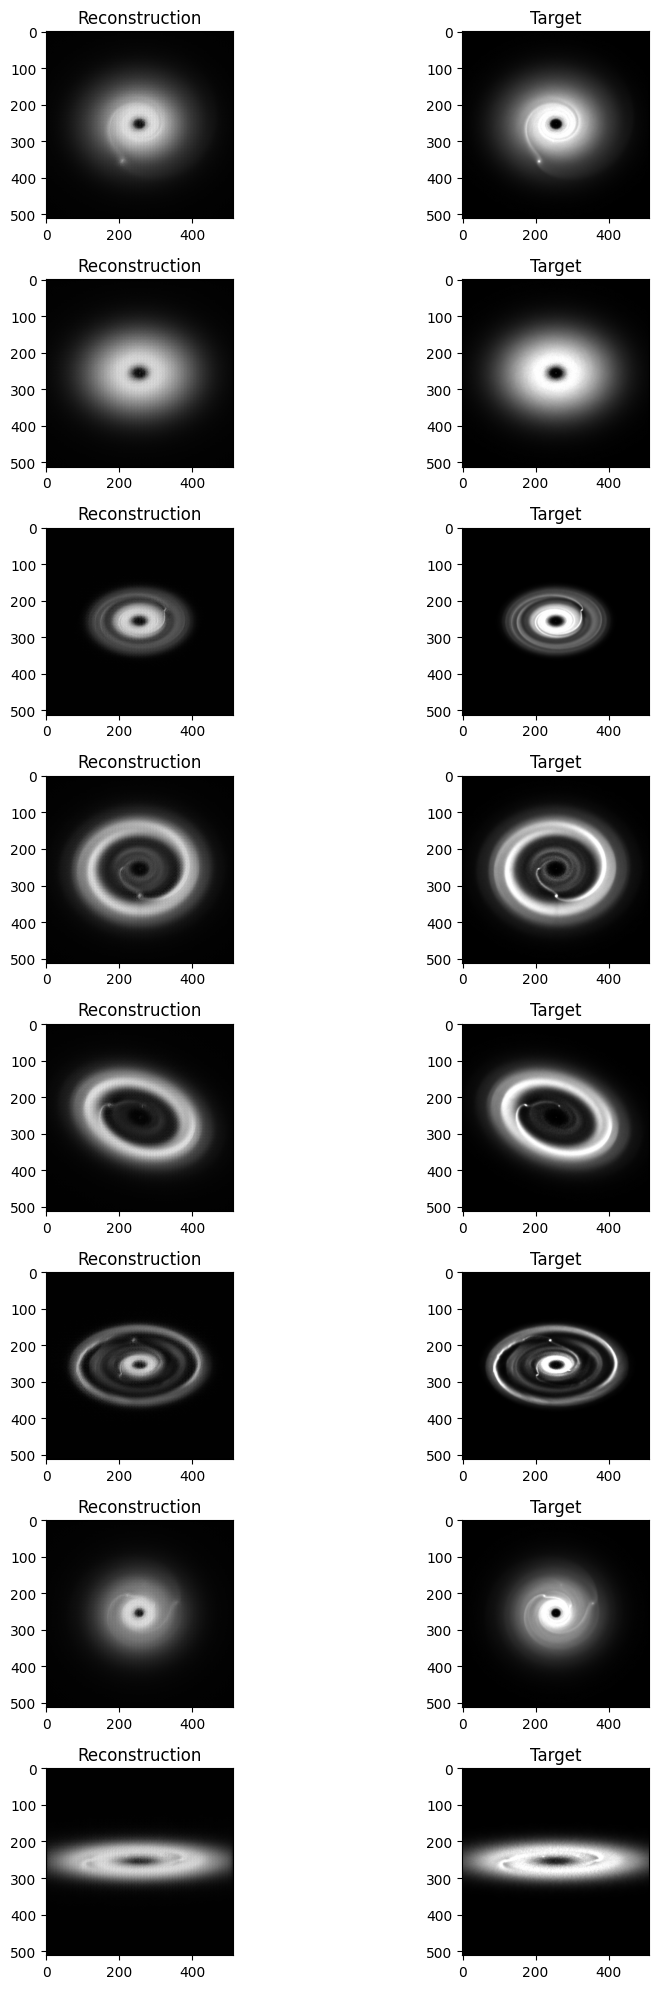

100%|██████████| 15/15 [00:00<00:00, 21.13it/s]


New best model saved with SSIM: 0.9470
MSE: 0.001576, PSNR: -inf, SSIM: 0.9470


100%|██████████| 9/9 [00:03<00:00,  2.39it/s]


Epoch 6/20, Loss: 0.001309


100%|██████████| 15/15 [00:00<00:00, 24.16it/s]


New best model saved with SSIM: 0.9627
MSE: 0.001118, PSNR: -inf, SSIM: 0.9627


100%|██████████| 9/9 [00:03<00:00,  2.30it/s]


Epoch 7/20, Loss: 0.001007


100%|██████████| 15/15 [00:00<00:00, 15.28it/s]


New best model saved with SSIM: 0.9724
MSE: 0.000872, PSNR: -inf, SSIM: 0.9724


100%|██████████| 9/9 [00:04<00:00,  2.19it/s]


Epoch 8/20, Loss: 0.000839


100%|██████████| 15/15 [00:00<00:00, 25.65it/s]


New best model saved with SSIM: 0.9769
MSE: 0.000740, PSNR: -inf, SSIM: 0.9769


100%|██████████| 9/9 [00:03<00:00,  2.36it/s]


Epoch 9/20, Loss: 0.000720


100%|██████████| 15/15 [00:00<00:00, 24.68it/s]


New best model saved with SSIM: 0.9799
MSE: 0.000657, PSNR: -inf, SSIM: 0.9799


100%|██████████| 9/9 [00:03<00:00,  2.25it/s]

Epoch 10/20, Loss: 0.000673


Validation Loss: 0.000598


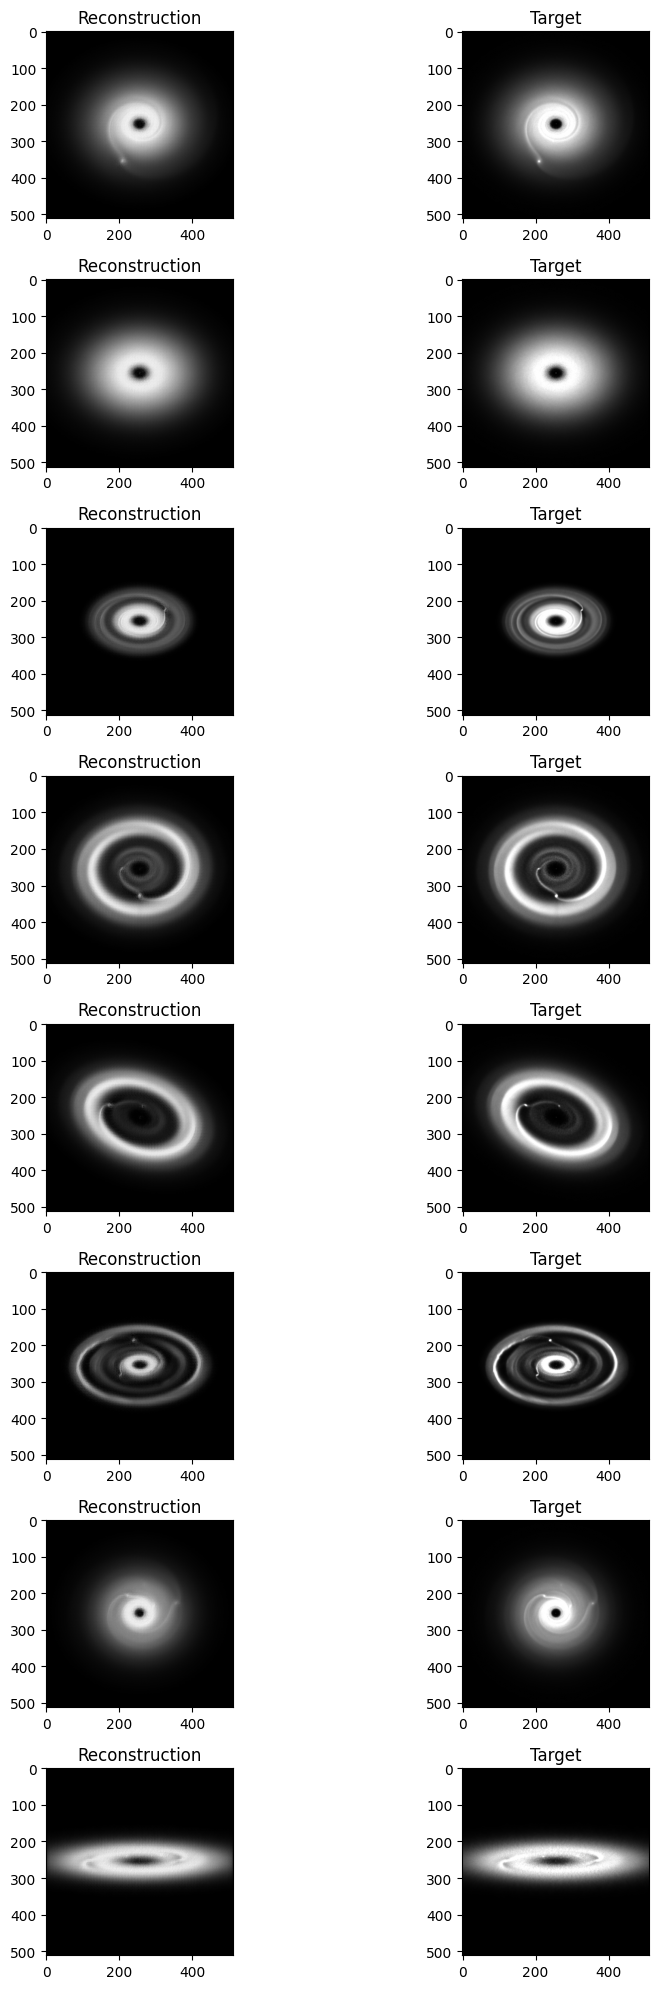

100%|██████████| 15/15 [00:00<00:00, 22.76it/s]


New best model saved with SSIM: 0.9819
MSE: 0.000598, PSNR: -inf, SSIM: 0.9819


100%|██████████| 9/9 [00:03<00:00,  2.36it/s]


Epoch 11/20, Loss: 0.000619


100%|██████████| 15/15 [00:00<00:00, 24.19it/s]


New best model saved with SSIM: 0.9834
MSE: 0.000551, PSNR: -inf, SSIM: 0.9834


100%|██████████| 9/9 [00:03<00:00,  2.36it/s]


Epoch 12/20, Loss: 0.000579


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


New best model saved with SSIM: 0.9843
MSE: 0.000515, PSNR: -inf, SSIM: 0.9843


100%|██████████| 9/9 [00:04<00:00,  2.03it/s]


Epoch 13/20, Loss: 0.000517


100%|██████████| 15/15 [00:00<00:00, 24.93it/s]


New best model saved with SSIM: 0.9850
MSE: 0.000490, PSNR: -inf, SSIM: 0.9850


100%|██████████| 9/9 [00:03<00:00,  2.51it/s]


Epoch 14/20, Loss: 0.000519


100%|██████████| 15/15 [00:00<00:00, 24.42it/s]


New best model saved with SSIM: 0.9856
MSE: 0.000465, PSNR: -inf, SSIM: 0.9856


100%|██████████| 9/9 [00:04<00:00,  2.23it/s]

Epoch 15/20, Loss: 0.000496


Validation Loss: 0.000442


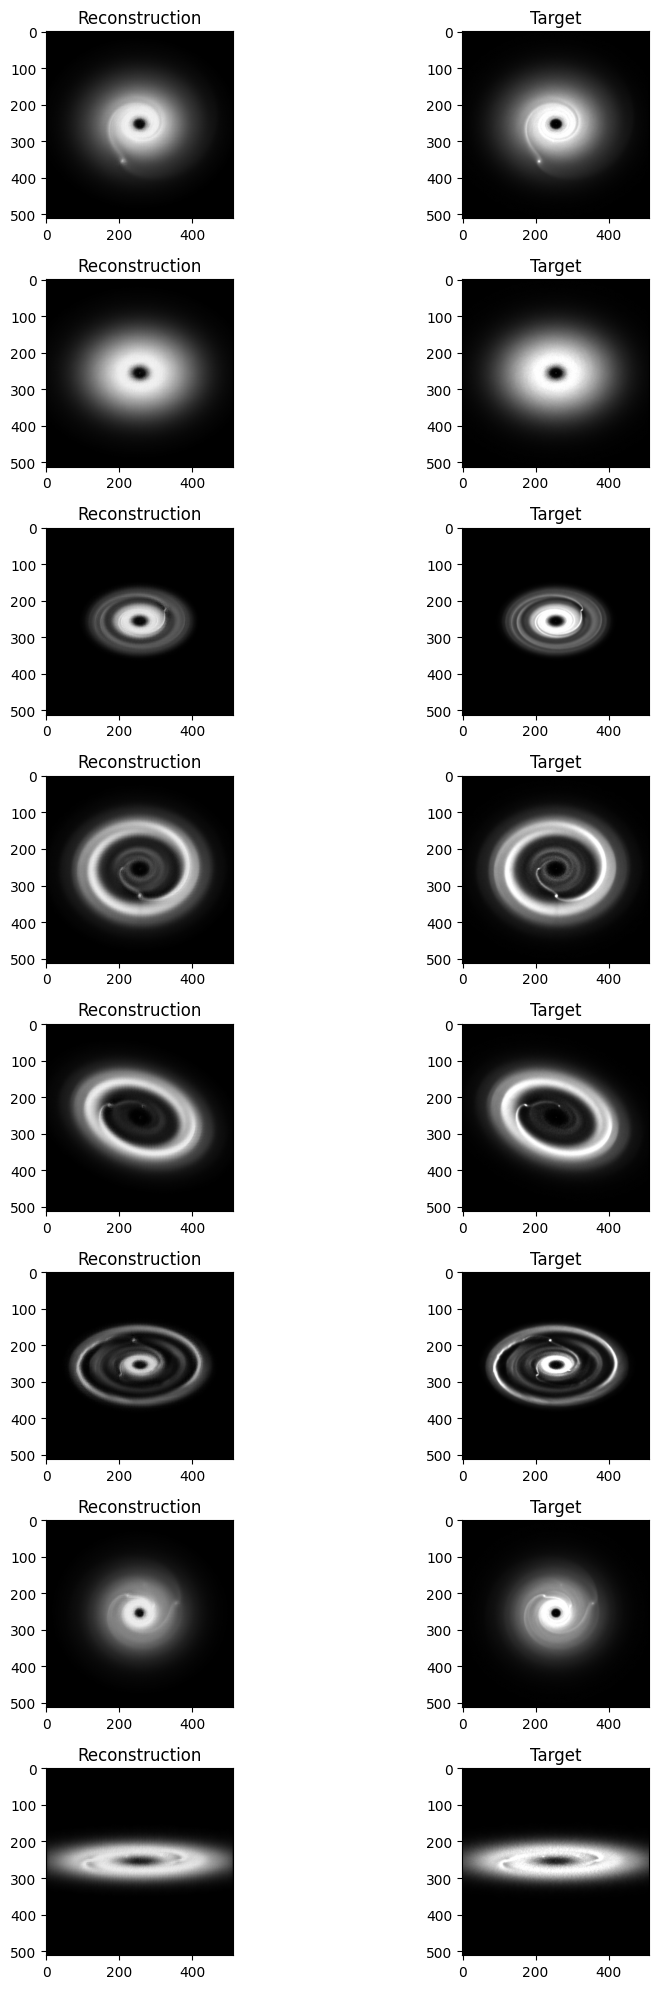

100%|██████████| 15/15 [00:00<00:00, 21.48it/s]


New best model saved with SSIM: 0.9861
MSE: 0.000442, PSNR: -inf, SSIM: 0.9861


100%|██████████| 9/9 [00:03<00:00,  2.38it/s]


Epoch 16/20, Loss: 0.000462


100%|██████████| 15/15 [00:00<00:00, 23.19it/s]


New best model saved with SSIM: 0.9866
MSE: 0.000422, PSNR: -inf, SSIM: 0.9866


100%|██████████| 9/9 [00:03<00:00,  2.31it/s]


Epoch 17/20, Loss: 0.000450


100%|██████████| 15/15 [00:00<00:00, 16.58it/s]


New best model saved with SSIM: 0.9871
MSE: 0.000405, PSNR: -inf, SSIM: 0.9871


100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


Epoch 18/20, Loss: 0.000449


100%|██████████| 15/15 [00:00<00:00, 24.39it/s]


New best model saved with SSIM: 0.9876
MSE: 0.000390, PSNR: -inf, SSIM: 0.9876


100%|██████████| 9/9 [00:03<00:00,  2.41it/s]


Epoch 19/20, Loss: 0.000413


100%|██████████| 15/15 [00:00<00:00, 23.59it/s]


New best model saved with SSIM: 0.9880
MSE: 0.000376, PSNR: -inf, SSIM: 0.9880


100%|██████████| 9/9 [00:03<00:00,  2.38it/s]

Epoch 20/20, Loss: 0.000400


Validation Loss: 0.000361


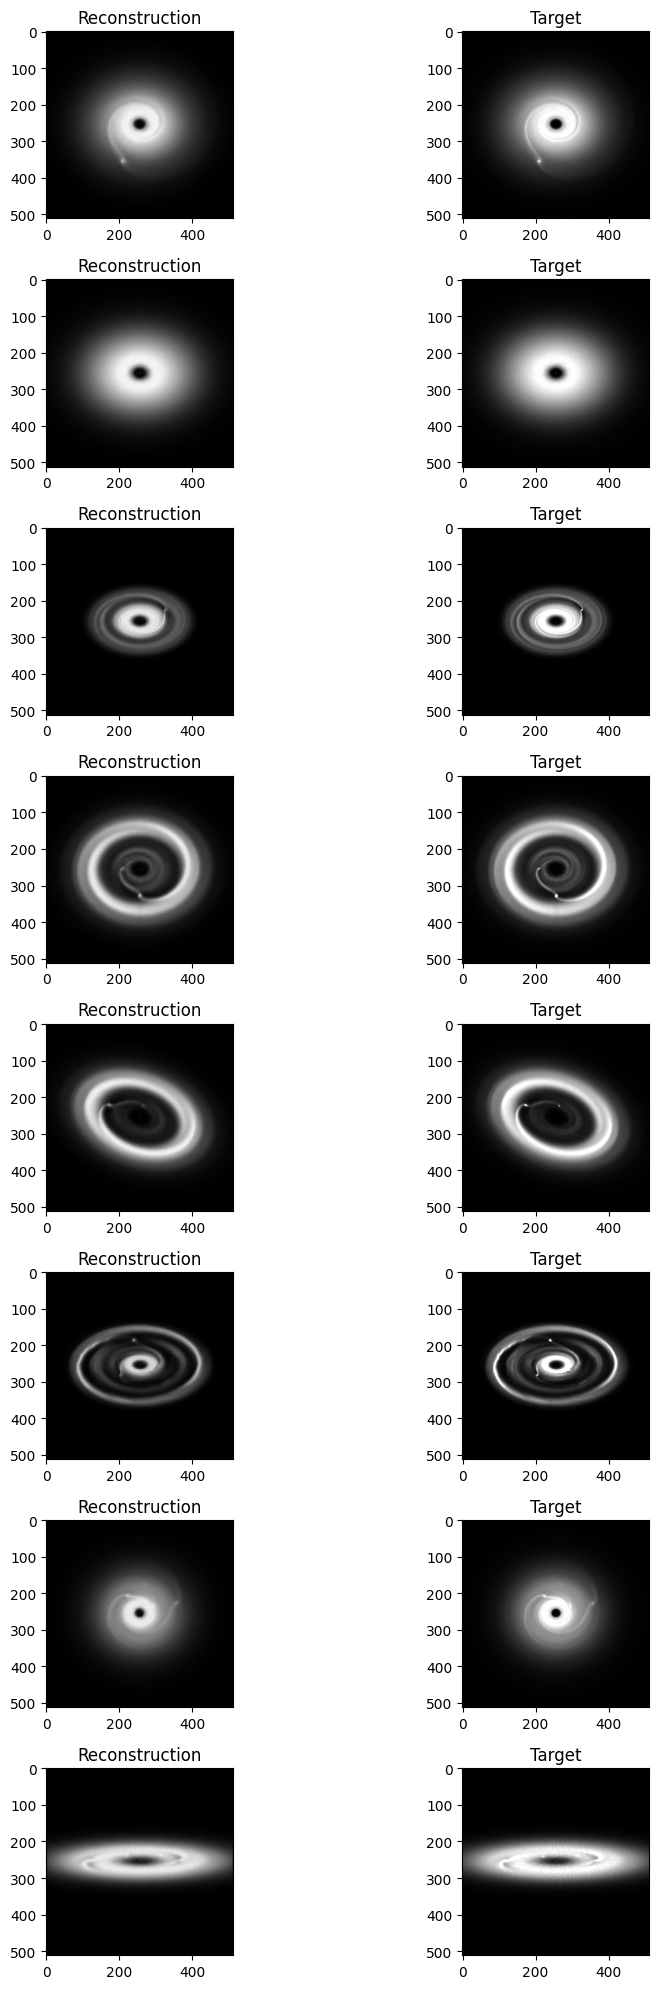

100%|██████████| 15/15 [00:00<00:00, 21.23it/s]

New best model saved with SSIM: 0.9885
MSE: 0.000361, PSNR: -inf, SSIM: 0.9885


In [29]:
# TRAINING AND METRICS FOR AUTOENCODER
def init_weights_kaiming(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
m = pytorch_msssim.MSSSIM()
model = UNet(out_channels=1).to(device)
model.apply(init_weights_kaiming)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Evaluation Function
def evaluate(model, test_loader, device="cuda"):
    model.eval()
    mse_total, psnr_total, ssim_total = 0, 0, 0
    best_ssim = 0.0
    best_model_path = "best_model.pth"

    all_ssim_scores = []

    with torch.no_grad():
        for img, target, _ in tqdm(test_loader):
            img, target = img.to(device), target.to(device)
            output, _ = model(img)
            # Compute Metrics
            ssim_score = m(output, target)
            output = output.cpu().numpy().squeeze()
            target = target.cpu().numpy().squeeze()

            mse = np.mean((output - target) ** 2)
            psnr = 20 * np.log10(target.max() / np.sqrt(mse + 1e-10))
            #ssim_score = ssim(output, target, data_range=target.max() - target.min())

            mse_total += mse
            psnr_total += psnr
            ssim_total += ssim_score
            all_ssim_scores.append(ssim_score)

    avg_ssim = ssim_total / len(test_loader)

    # Save model if the new SSIM is the best so far
    if avg_ssim > best_ssim:
        best_ssim = avg_ssim
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with SSIM: {best_ssim:.4f}")

    print(f"MSE: {mse_total / len(test_loader):.6f}, "
          f"PSNR: {psnr_total / len(test_loader):.2f}, "
          f"SSIM: {avg_ssim:.4f}")


# Validation Function
def validate(model, test_loader, device):
    model.eval()
    total_val_loss = 0
    images_input, images_target, images_output = [], [], []

    with torch.no_grad():
        for img, target, _ in test_loader:
            img, target = img.to(device), target.to(device)

            output, _ = model(img)
            loss = criterion(output, target)
            total_val_loss += loss.item()

            # Convert to numpy for visualization
            #images_input.append(img.cpu().numpy().squeeze())
            images_target.append(target.cpu().numpy().squeeze())
            images_output.append(output.cpu().numpy().squeeze())

            if len(images_input) >= 8:
                break

    print(f"Validation Loss: {total_val_loss / len(test_loader):.6f}")

    # Display 8 sample images
    fig, axes = plt.subplots(8, 2, figsize=(10, 20))
    for i in range(8):
        #axes[i, 0].imshow(images_input[i], cmap="gray")
        #axes[i, 0].set_title("Input")
        axes[i, 0].imshow(images_output[i], cmap="gray")
        axes[i, 0].set_title("Reconstruction")
        axes[i, 1].imshow(images_target[i], cmap="gray")
        axes[i, 1].set_title("Target")

    plt.tight_layout()
    plt.show()

# Training Loop
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for img, target, _ in tqdm(train_loader):
        img, target = img.to(device), target.to(device)

        optimizer.zero_grad()
        output, _ = model(img)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.6f}")
    if (epoch + 1) % 5 == 0:
        validate(model, test_loader, device=device)

    evaluate(model, test_loader, device=device)


Validation Loss: 0.000361


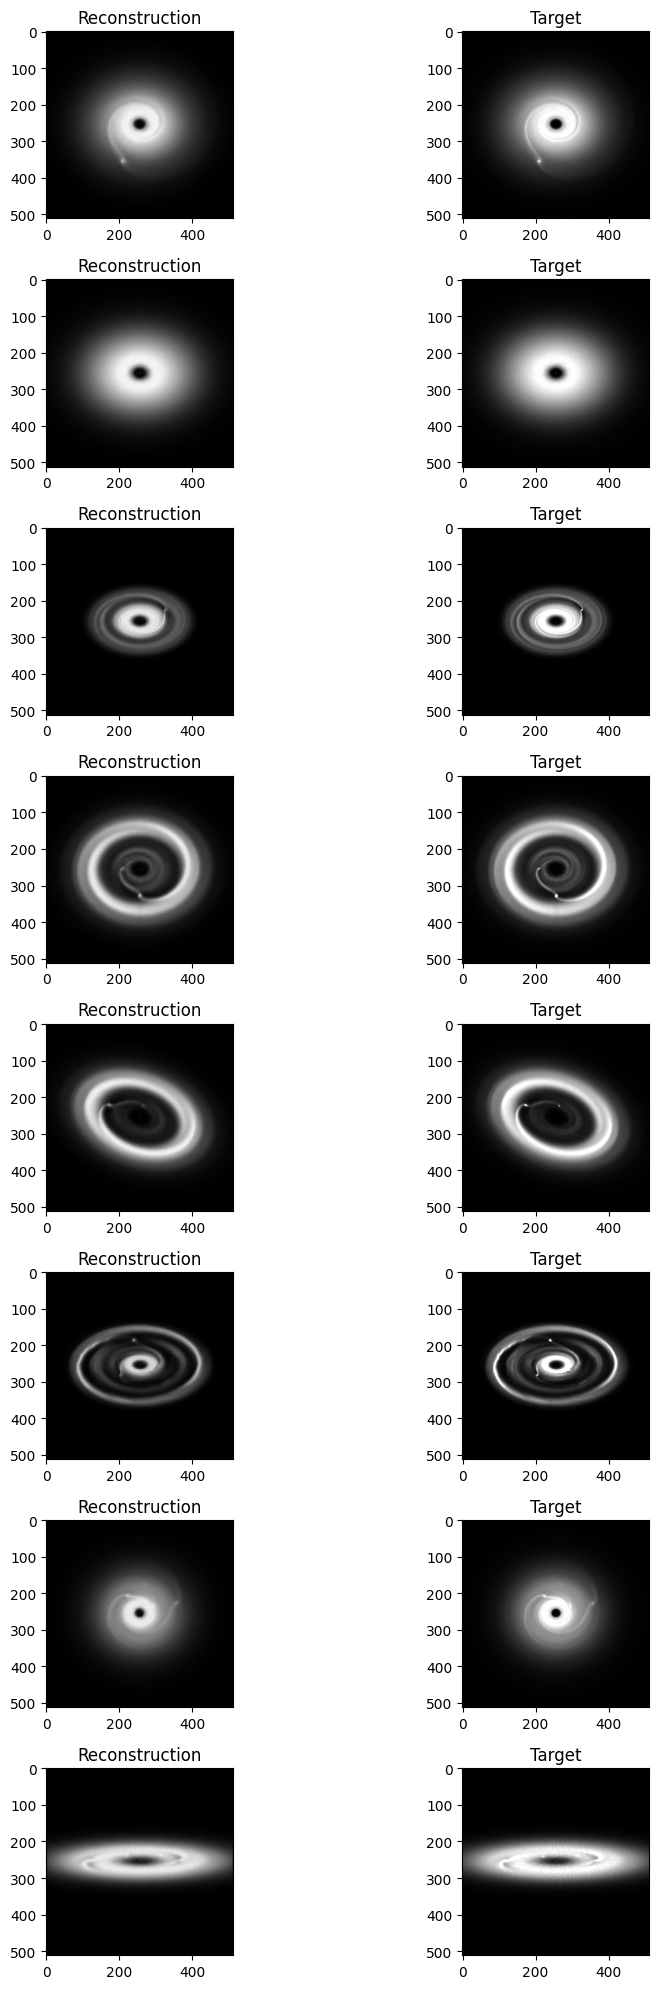

 87%|████████▋ | 13/15 [00:00<00:00, 24.12it/s]<ipython-input-29-46de888952f9>:36: RuntimeWarning: divide by zero encountered in log10
  psnr = 20 * np.log10(target.max() / np.sqrt(mse + 1e-10))
100%|██████████| 15/15 [00:01<00:00, 14.89it/s]

New best model saved with SSIM: 0.9885
MSE: 0.000361, PSNR: -inf, SSIM: 0.9885


In [30]:
# CARRY OUT VALIDATION WITH SAVED MODEL
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(out_channels=1).to(device)
model.load_state_dict(torch.load("best_model.pth"), strict= True)

validate(model, test_loader, device=device)
evaluate(model, test_loader, device=device)